In [1]:
# import libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Optional
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [2]:
# load data
data_location = f'./local'
train_file_name = 'train.csv'
test_file_name = 'test.csv'

In [3]:
df_train = pd.read_csv(os.path.join(data_location, train_file_name))
df_test = pd.read_csv(os.path.join(data_location, test_file_name))

### Data Cleansing

step 1. remove outliers, if any

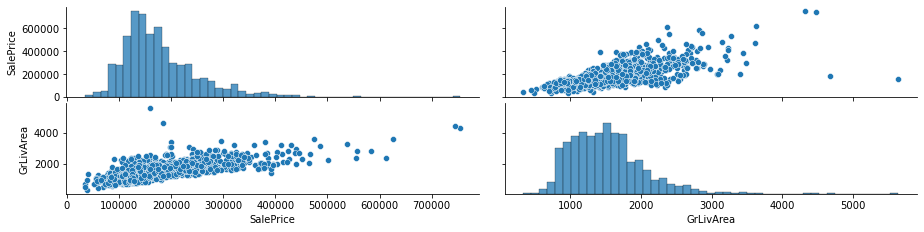

In [4]:
img = sns.pairplot(df_train[['SalePrice', 'GrLivArea']])
img.fig.set_size_inches(15,3)

In [5]:
# it should be a linear relationship between sales price and ground live area
# there are exceptional cases where it should be dropped from the training set
df_train.drop(df_train[(df_train['SalePrice'] < 300000) & (df_train['GrLivArea'] > 4000)].index, inplace=True)

step 2. fill null columns

In [6]:
df_train.columns[df_train.isnull().sum() > 0]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [7]:
df_test.columns[df_test.isnull().sum() > 0]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

In [8]:
# based on data description file, several fields
# are expected to be null provided it means No
# such features.
fill_none_cols = ['Alley', 'MasVnrType',  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                  'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu','GarageType', 
                  'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                  'MiscFeature']
fill_zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                  'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
                  'GarageCars', 'GarageArea', ]
fill_freq_cols = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
                  'KitchenQual', 'Functional', 'SaleType', 'Electrical']
fill_med_cols = ['LotFrontage']
to_str_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']

In [9]:
def _fill_missing_fields(df: pd.DataFrame, 
                        fill_none_cols: Optional[list] = None, 
                        fill_zero_cols: Optional[list] = None, 
                        fill_freq_cols: Optional[list] = None,
                        fill_med_cols: Optional[list] = None) -> pd.DataFrame:
    freq_impute = SimpleImputer(strategy='most_frequent')
    med_impute = SimpleImputer(strategy='median')
    
    df[fill_none_cols] = df[fill_none_cols].fillna('None')
    df[fill_zero_cols] = df[fill_zero_cols].fillna(0)
    df[fill_freq_cols] = freq_impute.fit_transform(df[fill_freq_cols])
    df[fill_med_cols] = med_impute.fit_transform(df[fill_med_cols])
    
    return df

In [10]:
def _change_dtype(df: pd.DataFrame, 
                  to_str_cols: Optional[list] = None) -> pd.DataFrame:
    df[to_str_cols] = df[to_str_cols].astype(str)
    return df

In [11]:
def transform_df(df: pd.DataFrame,
                fill_none_cols: Optional[list] = None, 
                fill_zero_cols: Optional[list] = None, 
                fill_freq_cols: Optional[list] = None,
                fill_med_cols: Optional[list] = None,
                to_str_cols: Optional[list] = None) -> pd.DataFrame:
    df = _fill_missing_fields(df, fill_none_cols, fill_zero_cols,
                             fill_freq_cols, fill_med_cols)
    df = _change_dtype(df, to_str_cols)
    assert len(df.columns[df.isnull().sum()>0])==0, ("still missing field(s) in the dataframe")
    return df

In [12]:
# one hot transformation
def one_hot_encode(df: pd.DataFrame):
    newDF = df.copy()
    obj_cols = list(newDF.select_dtypes(include='object'))
    try: obj_cols.remove('type')
    except: pass
    for col in obj_cols:
        dummies = pd.get_dummies(newDF[col], prefix=col)
        newDF = pd.concat([newDF, dummies], axis=1)
        newDF.drop(columns=col, inplace=True)
    return newDF

In [13]:
df_train = transform_df(df_train, fill_none_cols, fill_zero_cols,
                        fill_freq_cols, fill_med_cols, to_str_cols)
df_test = transform_df(df_test, fill_none_cols, fill_zero_cols,
                       fill_freq_cols, fill_med_cols, to_str_cols)

In [14]:
# combine train and test dataframe for one-hot encoding
# the combination prevents values in test set does not
# exist in train set
df_train['type'] = 'train'
df_test['type'] = 'test'
df_merge = pd.concat([df_train, df_test], ignore_index=True).reset_index(drop=True)

In [15]:
cols_to_label = ['Alley','BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure',
                 'CentralAir', 'ExterQual', 'ExterCond', 'Fence', 'FireplaceQu', 'Functional',
                 'GarageQual', 'GarageCond', 'GarageFinish', 'HeatingQC', 'KitchenQual',  
                 'LandSlope', 'LotShape', 'MoSold', 'MSSubClass', 'OverallCond', 
                 'PavedDrive', 'PoolQC', 'Street', 'YrSold', ]
for col in cols_to_label:
    label = LabelEncoder()
    df_merge[col] = label.fit_transform(list(df_merge[col].values))

In [16]:
df_merge = one_hot_encode(df_merge)
df_merge = df_merge.loc[:,~df_merge.columns.duplicated()]
df_merge.shape

(2917, 224)

In [17]:
# drop high correlation columns
tmp = df_merge.corr().abs()[df_merge.corr().abs() != 1].unstack()
cols_high_corr = list(tmp[tmp >.8].sort_values(ascending=False).drop_duplicates().unstack().columns)

In [18]:
df_merge.drop(columns=cols_high_corr, inplace=True)
df_merge.shape

(2917, 207)

### Model

As the dataset does not contain so many records but with relatively large amount of features, Support vector machines are used in such scenarios. In particular, NuSVR will be used by using parameter Nu to control the number of support vectors.<br>
Therefore, data cleansing/preprocessing is required.

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
standard_x = StandardScaler()
standard_y = StandardScaler()

In [21]:
cols_irrelevant = ['type', 'Id']
x_col = list(df_merge.columns)
y_col = 'SalePrice'
for col in cols_irrelevant:
    x_col.remove(col)
x_col.remove(y_col)

In [22]:
# transform features
standard_x.fit(df_merge[x_col])
df_merge[x_col] = standard_x.transform(df_merge[x_col])

In [23]:
# transform target
standard_y.fit(np.array(df_merge[y_col]).reshape(-1,1))
df_merge[y_col] = standard_y.transform(np.array(df_merge[y_col]).reshape(-1,1))

In [24]:
df_train = df_merge[df_merge['type'] == 'train']
df_test = df_merge[df_merge['type'] == 'test']
df_train.drop(columns='type', inplace=True)
df_test.drop(columns='type', inplace=True)

In [25]:
df_train.shape

(1458, 206)

### Neural Network

In [28]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

In [29]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [30]:
# build model
model = Sequential(name='Simple_Regression_Model')
model.add(Input(len(x_col)))
model.add(Dense(128, activation=tf.nn.relu, kernel_initializer='he_uniform'))
model.add(Dense(64, activation=tf.nn.relu))
model.add(Dense(32, activation=tf.nn.relu))
model.add(Dense(8, activation=tf.nn.relu))
model.add(Dense(1))

model.compile(loss = root_mean_squared_error, optimizer='Adam', metrics=['mse'])

In [31]:
model.summary()

Model: "Simple_Regression_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               26240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 36,849
Trainable params: 36,849
Non-trainable params: 0
_________________________________________________________________


In [32]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_mse')<.01):
            print('MSE of validation set is smaller than 1%')
            self.model.stop_training = True

callback_model = Callback()

In [33]:
%%time
history = model.fit(df_train[x_col].values, df_train[y_col].values, 
                    validation_split=.1,
                    epochs=1000, 
                    batch_size=10,
                    callbacks=[callback_model],
                    verbose=0)

Wall time: 1min 30s


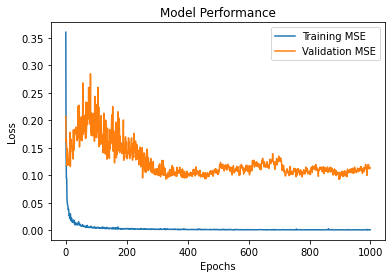

In [34]:
# plot training behavior
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch

plt.figure()
plt.plot(hist['epochs'], hist['mse'], label='Training MSE')
plt.plot(hist['epochs'], hist['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance')
plt.legend()
plt.show()

In [35]:
# store trained result
filename = './model/sixthSubmission.h5'
model.save(filename)

In [36]:
# generate result dataframe
df_test['y_pred'] = standard_y.inverse_transform(model.predict(df_test[x_col]))
submission = df_test[['Id', 'y_pred']].rename(columns={'y_pred':y_col})
submission.to_csv('./submission/sixthSubmission.csv', index=False, header=True)